## Colab Ortamına Verileri Getirme

In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="i9LzeK4katQnOr7iunyf")
# project = rf.workspace("samrat-sahoo").project("license-plates-f8vsn")
# dataset = project.version(5).download("tensorflow")


## İmport

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

## Verileri Yükleme

In [4]:
def veriler_yükle(files, folder, annotations_df):
    images = []
    labels = []

    for file in files:
        image_path = os.path.join(folder, file)
        image = cv2.imread(image_path)

        label_info = annotations_df[annotations_df["filename"] == file].iloc[0]
        label = [label_info["xmin"], label_info["ymin"], label_info["xmax"], label_info["ymax"]]
        labels.append(label)

        images.append(image)

    return np.array(images), np.array(labels)

## Gereksiz Sutun Var İse Kaldırma

In [5]:
def gereksiz_stunları_sil(df, sutunName):
  df = df.drop(sutunName, axis=1)
  return df

## Resmi İsteğe Bağlı Yeniden Boyutlandırma

In [6]:
def resmi_yediden_boyutla(images, labels):
    yeniImages = []
    yeniLabels = []

    new_size = (64, 64)
    for i in range(len(images)):
        img = tf.image.rgb_to_grayscale(images[i])
        img = tf.image.resize(img, new_size)
        yeniImages.append(img)

        x_min, y_min, x_max, y_max = labels[i]
        yeni_x_min = int(x_min * 64 / 416)
        yeni_y_min = int(y_min * 64 / 416)
        yeni_x_max = int(x_max * 64 / 416)
        yeni_y_max = int(y_max * 64 / 416)
        yeniLabels.append([yeni_x_min, yeni_y_min, yeni_x_max, yeni_y_max])

    return yeniImages, yeniLabels


## Dosyaları Çekme Ve Bölme

In [7]:
data_folder = "/content/License-Plates-5/train"
image_files = [f for f in os.listdir(data_folder) if f.endswith(".jpg")]
annotations_df = pd.read_csv(os.path.join(data_folder, "/content/_annotations.csv"))

train_files, test_files = train_test_split(image_files, test_size=0.25, random_state=42)


## annotations_df dosaysınındaki verileri İnceleme

In [33]:
annotations_df.head()

,filename,width,height,xmin,ymin,xmax,ymax
0,2b97f5bf137ee8d1_jpg.rf.fb1e17082f41aa19a8e5c2...,416,416,36,186,53,194
1,2b97f5bf137ee8d1_jpg.rf.fb1e17082f41aa19a8e5c2...,416,416,58,258,92,288
2,2b97f5bf137ee8d1_jpg.rf.fb1e17082f41aa19a8e5c2...,416,416,381,223,416,242
3,2b97f5bf137ee8d1_jpg.rf.fb1e17082f41aa19a8e5c2...,416,416,0,82,416,354
4,5df8816356fc2b29_jpg.rf.fb1577ff779568e5bb5c40...,416,416,14,268,26,293


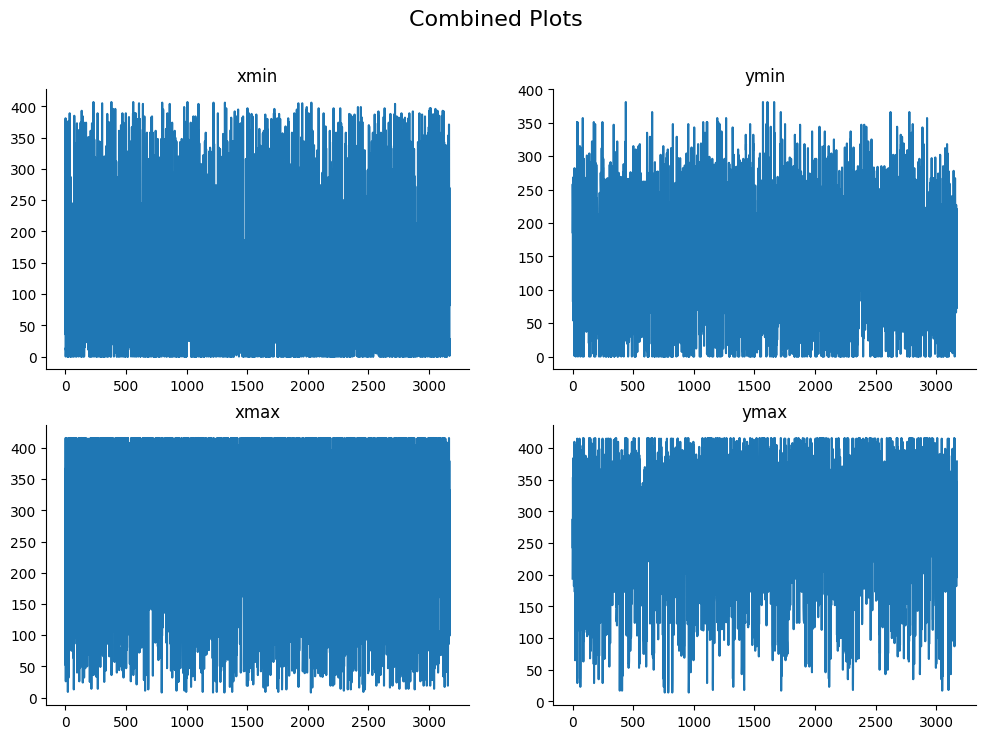

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

annotations_df['xmin'].plot(kind='line', ax=axs[0, 0], title='xmin')
axs[0, 0].spines[['top', 'right']].set_visible(False)

annotations_df['ymin'].plot(kind='line', ax=axs[0, 1], title='ymin')
axs[0, 1].spines[['top', 'right']].set_visible(False)

annotations_df['xmax'].plot(kind='line', ax=axs[1, 0], title='xmax')
axs[1, 0].spines[['top', 'right']].set_visible(False)

annotations_df['ymax'].plot(kind='line', ax=axs[1, 1], title='ymax')
axs[1, 1].spines[['top', 'right']].set_visible(False)

plt.suptitle('Combined Plots', fontsize=16)

plt.show()

In [ ]:
annotations_df['ymax'].plot(kind='line', figsize=(8, 4), title='ymax')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
annotations_df['ymin'].plot(kind='line', figsize=(8, 4), title='ymin')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
annotations_df['xmin'].plot(kind='line', figsize=(8, 4), title='xmin')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
annotations_df['xmax'].plot(kind='line', figsize=(8, 4), title='xmax')
plt.gca().spines[['top', 'right']].set_visible(False)

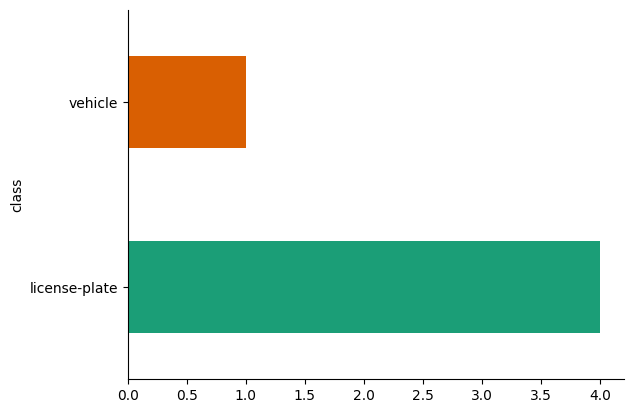

In [25]:
annotations_df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

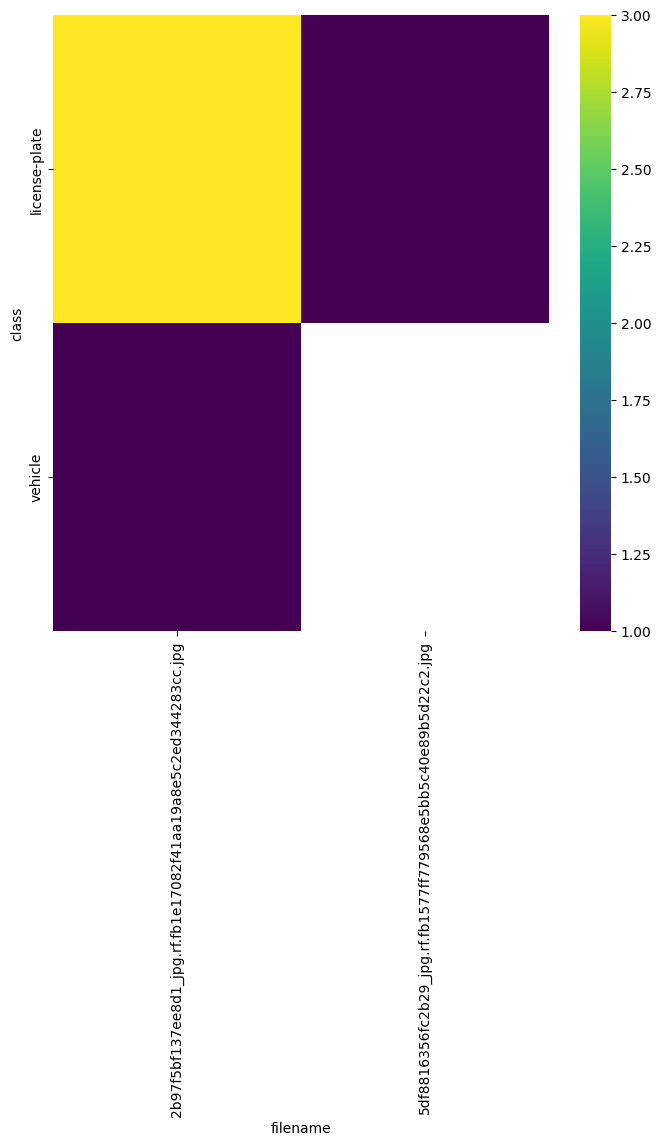

In [15]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['class'].value_counts()
    for x_label, grp in _df_17.groupby('filename')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('filename')
_ = plt.ylabel('class')



## Gereksiz Sütunları silme

In [26]:
annotations_df=gereksiz_stunları_sil(annotations_df ,['class'] )
print(type(train_files))

<class 'list'>


## Verileri istediğimiz Formata Dönüştürme

In [27]:
# Eğitim ve test verilerini yükle
train_images, train_labels = veriler_yükle(train_files, data_folder, annotations_df)
test_images, test_labels = veriler_yükle(test_files, data_folder, annotations_df)

## Resmi Deneme Amaçlı Boyut değişme

In [28]:
a,b=resmi_yediden_boyutla(train_images, train_labels)
c,d =resmi_yediden_boyutla(test_images, test_labels)

In [29]:
a= np.array(a)
b= np.array(b)
c= np.array(c)
d= np.array(d)
a.shape

(734, 64, 64, 1)

In [30]:
train_images.shape
type(train_images)

numpy.ndarray

In [31]:
train_labels.shape

(734, 4)

## Model Oluşturma ve Eğitim

In [38]:

model = Sequential()


model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(4, activation='softmax'))  # 4 çıkış nöronu, koordinatları temsil eder.

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.fit(a, b, epochs=10, validation_data=(c, d))


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 6, 6, 128)       